# Load data for analysis

In [1]:
import pickle
with open('./data/nightlights/nlight_downsampled_combined.pkl', 'rb') as fp:
    nlights = pickle.load(fp)

## Load an example file to find out latitudes and longitudes
* Method from [here](https://gis.stackexchange.com/questions/129847/obtain-coordinates-and-corresponding-pixel-values-from-geotiff-using-python-gdal)

In [8]:
from affine import Affine
import rasterio
from pyproj import Proj, transform
fname = './data/nlights_downsampled/F101993.v4b_web.stable_lights.avg_vis_downsampled.tif'
# Read raster
with rasterio.open(fname) as r:
    T0 = r.transform  # upper-left pixel corner affine transform
    p1 = Proj(r.crs)
    A = r.read()  # pixel values
# All rows and columns
cols, rows = np.meshgrid(np.arange(A.shape[2]), np.arange(A.shape[1]))

# Get affine transform for pixel centres
T1 = T0 * Affine.translation(0.5, 0.5)
# Function to convert pixel row/column index (from 0) to easting/northing at centre
rc2en = lambda r, c: (c, r) * T1

# All eastings and northings (there is probably a faster way to do this)
eastings, northings = np.vectorize(rc2en, otypes=[np.float, np.float])(rows, cols)

# Project all longitudes, latitudes
p2 = Proj(proj='latlong',datum='WGS84')
lons, lats = transform(p1, p2, eastings, northings)

In [3]:
import matplotlib.pyplot as plt
import jupyterthemes
import seaborn as sns
from jupyterthemes import jtplot
jupyterthemes.jtplot.style('onedork')
sns.set()

In [5]:
from eofs.standard import Eof
import importlib as imp
import numpy as np
# imp.reload(Eof)
solver = Eof(np.array(nlights["data"]), center=True)

Shape of spatial compenenents (timexlongxlat) =  (21, 2160, 4320)
Shape for time components :  (21, 21)


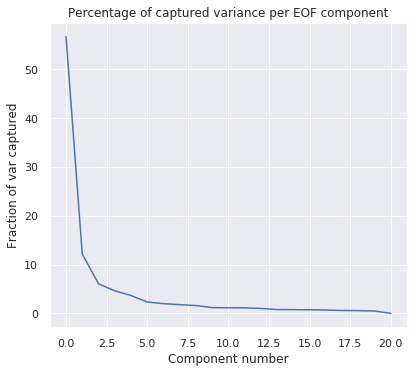

In [6]:
spatial_components = solver.eofs()
pc_time = solver.pcs()
# dims = (len(lats), len(lons))
var_frac = solver.varianceFraction()
print("Shape of spatial compenenents (timexlongxlat) = ", spatial_components.shape)
print("Shape for time components : ", pc_time.shape)
fig, ax = plt.subplots()
ax.plot(range(len(var_frac)), 100*var_frac)
ax.set_title("Percentage of captured variance per EOF component")
ax.set_xlabel("Component number")
ax.set_ylabel("Fraction of var captured")
plt.savefig('./plots/nlights_EOF/variance_capture_plot.png', format='png', dpi=1000)

In [32]:
lons[0, :]

array([-179.96249904, -179.87916377, -179.79582851, ...,  179.79582707,
        179.87916233,  179.9624976 ])

In [40]:
min(lats[:, 0])

-64.97175677035989

In [44]:
plt.rcParams['savefig.facecolor'] = 'white'

In [46]:
plt.ion()

3470.842379791039

In [ ]:
from mpl_toolkits.basemap import Basemap, maskoceans
import tqdm
# lons, lats =  range(4320), range(2160)
years = range(1993, 2014)
for i in tqdm.tqdm(range(10)):
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(20, 10), gridspec_kw={'height_ratios': [3, 1]})
    print(len(lons), len(lats))
    m = Basemap(projection='cyl', 
#                 llcrnrlon=min(lons[0, :]),
#                 llcrnrlat=min(lats[:, 0]),
#                 urcrnrlon=max(lons[0, :]),
#                 urcrnrlat=max(lats[:, 0]),
                lon_0 = 0,
                lat_0 = 0,
                ax=ax[0],
#                 width=10,
               resolution = 'i')
#     x, y = m(*np.meshgrid(lons, lats))
    x, y = lons, lats
    vals = maskoceans(x, y, spatial_components[i,:,:].squeeze())
    clevs = np.linspace(np.min(vals), np.max(vals), 50)
    cs = m.contourf(x, y, vals, cmap = plt.cm.coolwarm)
    m.drawcoastlines()
    m.drawcountries()
    cb = m.colorbar(cs, 'right', size='5%', pad='2%')
    cb.set_label('EOF', fontsize=12)
    ax[0].set_title('EOF spatial component number {}'.format(i))
#     ax[1].set_title('EOF ' + str(i+1), fontsize=16)
    ax[1].plot(years, pc_time[:,i], linewidth=2)
    ax[1].set_title('Temporal coefficient for EOF_{} over time'.format(i))
    ax[1].set_xlabel('Measurement Year')
    ax[1].set_ylabel('Coefficient value')
    ax[1].set_ylim((np.min(pc_time[:,:10]), np.max(pc_time[:,:10])))
#     ax[1].set_facecolor('xkcd:salmon')
    plt.plot()
    plt.savefig('./plots/nlights_EOF/EOF_{}.png'.format(i), format='png')

  0%|          | 0/10 [00:00<?, ?it/s]/home/armaan/anaconda3/envs/_gis/lib/python3.7/site-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


2160 2160


/home/armaan/anaconda3/envs/_gis/lib/python3.7/site-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
/home/armaan/anaconda3/envs/_gis/lib/python3.7/site-packages/ipykernel_launcher.py:24: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
 10%|█         | 1/10 [00:08<01:14,  8.32s/it]/home/armaan/anaconda3/envs/_gis/lib/python3.7/site-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


2160 2160


/home/armaan/anaconda3/envs/_gis/lib/python3.7/site-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
/home/armaan/anaconda3/envs/_gis/lib/python3.7/site-packages/ipykernel_launcher.py:24: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
 20%|██        | 2/10 [00:16<01:06,  8.33s/it]/home/armaan/anaconda3/envs/_gis/lib/python3.7/site-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


2160 2160


/home/armaan/anaconda3/envs/_gis/lib/python3.7/site-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
/home/armaan/anaconda3/envs/_gis/lib/python3.7/site-packages/ipykernel_launcher.py:24: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
 30%|███       | 3/10 [00:24<00:57,  8.15s/it]/home/armaan/anaconda3/envs/_gis/lib/python3.7/site-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


2160 2160


/home/armaan/anaconda3/envs/_gis/lib/python3.7/site-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
/home/armaan/anaconda3/envs/_gis/lib/python3.7/site-packages/ipykernel_launcher.py:24: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
 40%|████      | 4/10 [00:32<00:49,  8.25s/it]/home/armaan/anaconda3/envs/_gis/lib/python3.7/site-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


2160 2160


/home/armaan/anaconda3/envs/_gis/lib/python3.7/site-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
/home/armaan/anaconda3/envs/_gis/lib/python3.7/site-packages/ipykernel_launcher.py:24: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
 50%|█████     | 5/10 [1:06:22<1:39:14, 1190.80s/it]/home/armaan/anaconda3/envs/_gis/lib/python3.7/site-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


2160 2160


/home/armaan/anaconda3/envs/_gis/lib/python3.7/site-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
/home/armaan/anaconda3/envs/_gis/lib/python3.7/site-packages/ipykernel_launcher.py:24: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
 60%|██████    | 6/10 [1:06:31<55:44, 836.13s/it]   /home/armaan/anaconda3/envs/_gis/lib/python3.7/site-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


2160 2160
